<a href="https://colab.research.google.com/github/Oleksandr190378/data-computing/blob/main/Hm_8_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.
y_train, y_test = np.array(y_train, np.int64), np.array(y_test, np.int64)
# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.dense1 = DenseLayer(in_features=784, out_features=128, name="dense1")
    self.dense2 = DenseLayer(in_features=128, out_features=256, name="dense2")
    # Вихідний шар
    self.output_layer = DenseLayer(in_features=256, out_features=10, name="output")


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.dense1(x)
    x = self.dense2(x)
    return self.output_layer(x, activation=1)

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Перетворюємо прогнози у клас з найбільшою ймовірністю
    y_pred_class = tf.argmax(y_pred, axis=1)

    # Порівнюємо передбачені класи з істинними
    correct_predictions = tf.equal(y_pred_class, y_true)

    # Обчислюємо середню точність
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))
  acc = accuracy(pred, output_y)

  return loss, acc

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss, acc = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())

        print(f"Step {step}, Loss: {loss.numpy():.4f}, Accuracy: {acc.numpy():.4f}")
print("Тренування завершено!")
print(f"Фінальна втрата: {loss_history[-1]:.4f}")
print(f"Фінальна точність: {accuracy_history[-1]:.4f}")

Step 100, Loss: 368.0961, Accuracy: 0.6719
Step 200, Loss: 219.0604, Accuracy: 0.7695
Step 300, Loss: 241.3264, Accuracy: 0.7266
Step 400, Loss: 190.5769, Accuracy: 0.8047
Step 500, Loss: 129.7103, Accuracy: 0.8438
Step 600, Loss: 138.0653, Accuracy: 0.8398
Step 700, Loss: 145.9818, Accuracy: 0.8438
Step 800, Loss: 133.6993, Accuracy: 0.8555
Step 900, Loss: 162.5202, Accuracy: 0.8359
Step 1000, Loss: 130.0631, Accuracy: 0.8711
Step 1100, Loss: 122.9849, Accuracy: 0.8516
Step 1200, Loss: 64.5790, Accuracy: 0.9141
Step 1300, Loss: 111.1902, Accuracy: 0.8750
Step 1400, Loss: 77.4328, Accuracy: 0.8945
Step 1500, Loss: 107.3707, Accuracy: 0.8828
Step 1600, Loss: 98.9165, Accuracy: 0.8867
Step 1700, Loss: 66.6702, Accuracy: 0.9258
Step 1800, Loss: 67.4764, Accuracy: 0.9219
Step 1900, Loss: 90.0407, Accuracy: 0.9062
Step 2000, Loss: 102.3243, Accuracy: 0.8945
Step 2100, Loss: 70.2340, Accuracy: 0.9062
Step 2200, Loss: 84.8722, Accuracy: 0.8984
Step 2300, Loss: 77.7100, Accuracy: 0.9023
Step 2

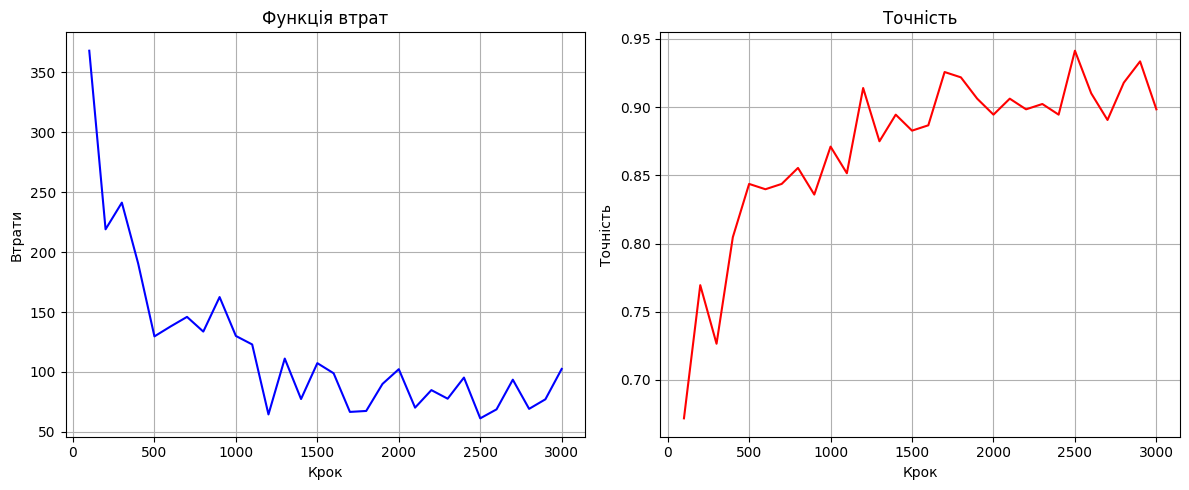

In [8]:
import matplotlib.pyplot as plt

# Підготовка даних для графіків
steps = range(display_step, training_steps + 1, display_step)

# Створення графіка функції втрат
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(steps, loss_history, 'b-')
plt.title('Функція втрат')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.grid(True)

# Створення графіка точності
plt.subplot(1, 2, 2)
plt.plot(steps, accuracy_history, 'r-')
plt.title('Точність')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.grid(True)

# Відображення обох графіків
plt.tight_layout()
plt.show()


In [9]:
# Створюємо тестовий датасет
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Ініціалізуємо змінні для зберігання загальної точності
total_accuracy = 0
num_batches = 0

# Проходимо через тестові дані
for batch_x, batch_y in test_data:
    # Отримуємо прогнози моделі
    pred = neural_net(batch_x)

    # Обчислюємо точність для поточного батчу
    batch_accuracy = accuracy(pred, batch_y)

    # Додаємо точність поточного батчу до загальної точності
    total_accuracy += batch_accuracy
    num_batches += 1

# Обчислюємо середню точність
average_accuracy = total_accuracy / num_batches

print(f"Точність на тестових даних: {average_accuracy:.4f}")

from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = np.argmax(neural_net(x_test).numpy(), axis=1)
y_true = y_test

cm = confusion_matrix(y_true, y_pred)

print("Матриця помилок:")
print(cm)

Точність на тестових даних: 0.9028
Матриця помилок:
[[ 935    0    3    6    0   18    5    1   11    1]
 [   1 1095    7    3    0    2    4    4   19    0]
 [  14    2  902   34   11    2   11   14   34    8]
 [   7    2   14  908    2   28    1   10   25   13]
 [   3    1    9    1  875    3   12   10   15   53]
 [  13    3    5   57   10  734   10   12   37   11]
 [  14    3    8    0    9   13  887    0   18    6]
 [   2    9   30    8    8    3    0  932    7   29]
 [   4    2   16   28   16   18    8    7  861   14]
 [  11    4    3   10   37   15    1   34   18  876]]


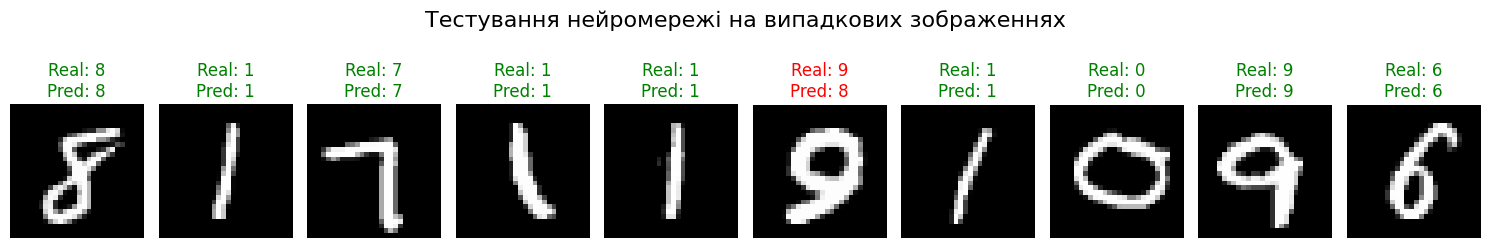


Точність на вибраних зображеннях: 0.90
Нейромережа помилилась на 1 з 10 зображень.


In [10]:

import numpy as np
import matplotlib.pyplot as plt

num_images = 10
random_indices = np.random.choice(len(x_test), num_images, replace=False)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

predictions = neural_net(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
fig.suptitle('Тестування нейромережі на випадкових зображеннях', fontsize=16)

for i in range(num_images):
    axes[i].imshow(sample_images[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')
    real = sample_labels[i]
    pred = predicted_labels[i]
    color = 'green' if real == pred else 'red'
    axes[i].set_title(f'Real: {real}\nPred: {pred}', color=color)

plt.tight_layout()
plt.show()
correct_predictions = np.sum(sample_labels == predicted_labels)
accuracy = correct_predictions / num_images

print(f"\nТочність на вибраних зображеннях: {accuracy:.2f}")
print(f"Нейромережа помилилась на {num_images - correct_predictions} з {num_images} зображень.")




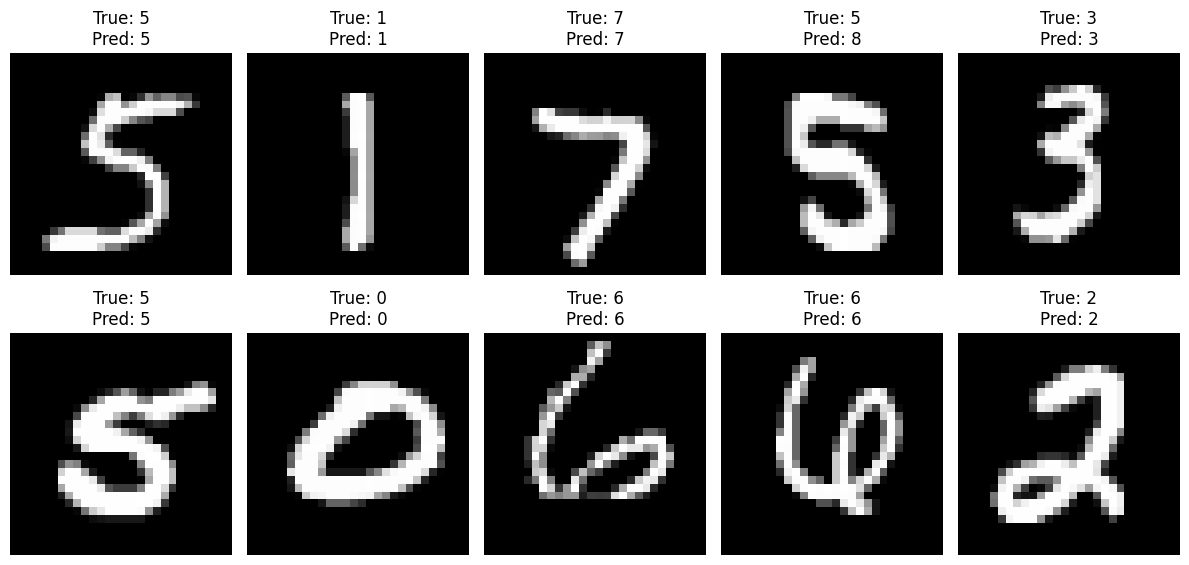

Точність на 10 зображеннях: 90.00%
Нейронна мережа помиляється на 1 зображеннях (10.00%).


In [12]:
import numpy as np
import matplotlib.pyplot as plt

random_indices = np.random.choice(x_test.shape[0], 5, replace=False)
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

additional_indices = np.random.choice(x_test.shape[0], 5, replace=False)
additional_images = x_test[additional_indices]
additional_labels = y_test[additional_indices]
test_images = np.concatenate((random_images, additional_images))
test_labels = np.concatenate((random_labels, additional_labels))

predictions = neural_net(test_images)
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {test_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

correct_predictions = np.sum(predicted_labels == test_labels)
accuracy = correct_predictions / 10.0
print(f"Точність на 10 зображеннях: {accuracy * 100:.2f}%")

if accuracy == 1.0:
    print("Нейронна мережа не помиляється на вибраних зображеннях.")
else:
    error_count = 10 - correct_predictions
    error_rate = (1 - accuracy) * 100
    print(f"Нейронна мережа помиляється на {error_count} зображеннях ({error_rate:.2f}%).")

In [13]:
from sklearn.metrics import classification_report

predicted_labels = neural_net(x_test)
predicted_labels = np.argmax(predicted_labels, axis=1)

report = classification_report(y_test, predicted_labels)

print(report)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       980
           1       0.98      0.96      0.97      1135
           2       0.90      0.87      0.89      1032
           3       0.86      0.90      0.88      1010
           4       0.90      0.89      0.90       982
           5       0.88      0.82      0.85       892
           6       0.94      0.93      0.94       958
           7       0.91      0.91      0.91      1028
           8       0.82      0.88      0.85       974
           9       0.87      0.87      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Модель демонструє добру
 точність (90%) у класифікації зображень, помиляється на зображеннях які графічно схожі

